Consider the finite problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) =
    \begin{cases}
        0 & -l < x <  l, \\
        V_0 &  otherwise.
    \end{cases}
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 20$, $h = 1, m = 1 $ and $V_0 = 10$

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
import pandas as pd  #for the moving average
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

from pyDOE import lhs #latin hypercube sampling

cuda
NVIDIA RTX A6000


In [2]:
#First and second derivatives from Automatic Differentiation
def dfx(f,x):
  u_x = []; u_xx = []
  for i in range(f.shape[1]):
    u_x.append(grad(f[:,i], x, grad_outputs=torch.ones_like(f[:,i]), create_graph=True)[0])
    u_xx.append(grad(u_x[i].view(-1), x, grad_outputs=torch.ones_like(f[:,i]), create_graph=True)[0])
  u_x = torch.cat(u_x, dim=1); u_xx = torch.cat(u_xx, dim=1)
  return u_x, u_xx

In [37]:
#Defining the hyperparameters
class config:
  def __init__(self):
    self.t0 = -10
    self.tf = 10
    self.xbc = 0
    self.eig_num = 5
    self.col_pts = 200
    self.layers = [1,100,100, 100,self.eig_num]
    self.epochs = 20000

cfg = config()

In [26]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,cfg):
  N1 = nn(t)
  f = ((1-torch.exp(-(t - cfg.t0)))*(1-torch.exp(t - cfg.tf))).view(-1,1)
  psi_hat = cfg.xbc + f*N1 #Broadcasting is done here
  return psi_hat

In [27]:
def hamEqs_Loss(t,psi, psi_xx, v): #Defines the PDE loss
  # Hamiltonian applied to psi
    hamEqs = -0.5 * psi_xx + v * psi
    numerator = torch.trapz(psi * hamEqs, t, dim=0)
    denominator = torch.trapz(psi ** 2, t, dim=0)
    E = numerator / denominator
    # Residual (Schrödinger equation)
    res = 0.5 *psi_xx + (E - v) * psi
    #L = res/(torch.abs(psi) + 1e-3)
    return res, E

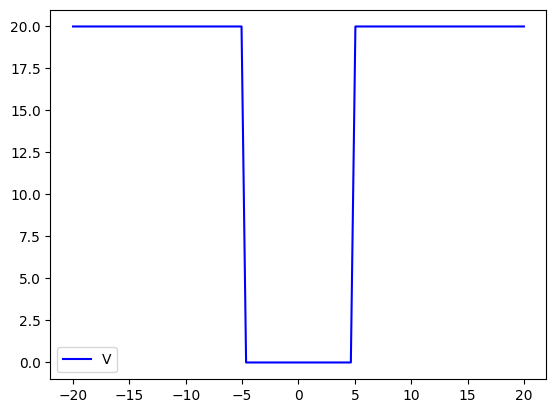

In [28]:
#Defining the potential well
def V(x):
  x = x.data.numpy()
  x0 = 5
  vnp = (np.heaviside(-x-x0,0) + np.heaviside(x-x0,0))*20
  #vnp = (np.heaviside(-x,0) + np.heaviside(x-x0,0))*20
  return torch.from_numpy(vnp)

x = torch.linspace(-20,20,100)
pot = V(x)
#scaled_pot = V_norm(x)

plt.plot(x,pot, 'b',label='V')
plt.legend()
plt.show()

In [29]:
#Defining the Frobenius norm
def frobenius_norm(G):
    I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
    loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
    return loss

#Defining the monotonicity_penalty, this is to ensure that the eigenpairs are learned monotonically
def monotonicity_penalty(E, margin = 0.0):
    diffs = E[:-1] - E[1:] + margin
    penalty = torch.relu(diffs).sum()    #torch.where(diffs > 0, torch.zeros_like(diffs), torch.exp(-diffs)).sum()       #
    return penalty

#Defining the cosine matrix
def cosine_matrix(psi,x):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=0))  # (k,)
  psi_normalized = psi / psi_norm  # (n, k)
  psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
  cos_matrix = torch.trapz(psi_prod, x, dim=0)
  return cos_matrix

#Norm loss to ensure the wavefunctions are properly scaled
def norm_loss(psi,x,cfg):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=0))  # (k,)
  scale_term = (cfg.tf - cfg.t0)*psi_norm/cfg.col_pts
  return torch.sum((1-scale_term).pow(2))

In [30]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,cfg):
    super(qNN,self).__init__()
    self.activation = torch.sin
    self.layers = cfg.layers

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers) - 1)])

    for i in range(len(self.layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)
    #Initializing the weights
    #with torch.no_grad():
    #  for i in range(len(self.layers)-1):
    #    if i ==0:
    #      self.linears[i].weight.uniform_(-1/self.layers[i], 1/self.layers[i])
    #    else:
    #      self.linears[i].weight.uniform_(-np.sqrt(6/self.layers[i]), np.sqrt(6/self.layers[i] ))



  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      a = self.activation(z)
      if i == 0:
        a = self.activation(20*z)
      else:
        a = self.activation(z)
    a = self.linears[-1](a)
    return a

In [31]:
#Defining group equivariant RqPINN
class equiRqNN(torch.nn.Module):
  def __init__(self,cfg):
    super(equiRqNN,self).__init__()
    self.activation = torch.sin #The activation function
    self.layers = cfg.layers

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers) - 1)])

    #Initializing the weights
    for i in range(len(self.layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      if i ==len(self.layers)-2:
        nn.init.zeros_(self.linears[i].bias.data) #Initializing the bias of the last layer to zeros
      else:
        nn.init.normal_(self.linears[i].bias.data)

  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x).float()
    a0 = torch.cat([x,-x], dim=0).view(2,-1,self.layers[0])
    #Implementing equivariance for l = 1
    z1 = self.linears[0](a0)
    a1 = self.activation(10.0*z1)

    #Implementing equivariance for 1 < l < L-1
    for i in range(1,len(self.linears)-1):
      z21 = self.linears[i](a1[0,:,:] - a1[1,:,:])
      z22 = self.linears[i](a1[1,:,:] - a1[0,:,:])
      z = torch.cat([z21,z22], dim = 0).view(2,-1,self.layers[i+1])
      a1 = self.activation(10.0*z)

    #Implementing equivariance for l = L
    out = self.linears[-1](a1[0,:,:] - a1[1,:,:])
    return out

#### Pre-Trainer

In [32]:
def fg(x, s):
  """Batch of Gaussians for different widths."""
  return torch.exp(-(x / s.unsqueeze(0)) ** 2)  # (n_points, n_functions)


In [33]:
#Pretrainer step
def pretrainer_step(NN, t_rand, psi_gauss):
  psi = NN(t_rand)
  #psi_normal = psi/torch.norm(psi, dim = 0, keepdim = True)
  loss = F.mse_loss(psi, psi_gauss)
  return loss

### Learning Rate Finder

In [38]:
#We want to find the best lr for our defined model
model_lr = qNN(cfg).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

In [39]:
def common_train_step(NN,t_rand,t_sort,idx,vx, cfg):
    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,cfg) #The forward pass
    psi = psi.to(device)
    #psi_normal = psi/torch.norm(psi, dim = 0, keepdim = True)

    # Compute second derivatives
    psi_x, psi_xx = dfx(psi, t_rand)

    psi_sort = psi[idx,:].to(device); psi_xx_sort = psi_xx[idx,:].to(device)

    L,E = hamEqs_Loss(t_sort,psi_sort,psi_xx_sort,vx)
    Loss = torch.nn.MSELoss()
    #Getting the losses after each forward pass
    pde_loss = 10.0*Loss(L,torch.zeros_like(L))  #The scaled pde_loss
    n_loss = norm_loss(psi_sort,t_sort,cfg)
    G = cosine_matrix(psi_sort, t_sort)
    cosine_loss = frobenius_norm(G)
    return pde_loss, n_loss, cosine_loss, E

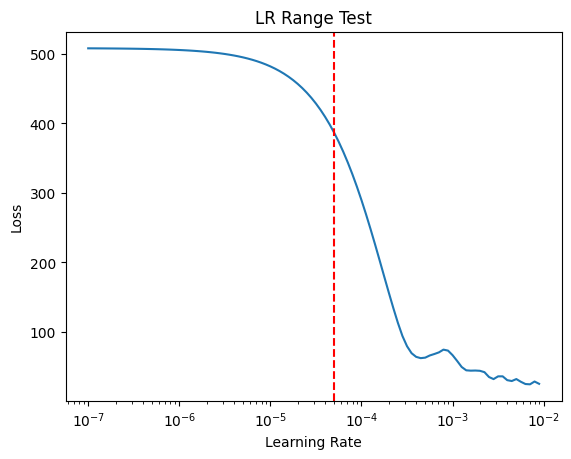

In [40]:
# Set up variables
x_lhs = torch.tensor(cfg.t0 + (cfg.tf - cfg.t0)*lhs(1,cfg.col_pts)).view(-1,1).float()
#x_lhs.requires_grad =True
losses = []
lrs = []

#Sorting and unsorting here
# Sort only the coordinates, without gradients
with torch.no_grad():
    t_squeezed = x_lhs.squeeze(-1)
    t_sort, idx = torch.sort(t_squeezed, dim=0)

x_lhs = x_lhs.to(device)
x_lhs.requires_grad = True
vx = V(t_sort.unsqueeze(1)).to(device)
t_sort = t_sort.to(device)

start_lr = 1e-7
end_lr = 0.01
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    pde_loss, n_loss, cosine_loss,En= common_train_step(model_lr,x_lhs, t_sort,idx,vx,cfg)
    monotone_loss =monotonicity_penalty(En, margin = 0.1)
    loss = pde_loss + n_loss+ cosine_loss + monotone_loss
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.axvline(x=5e-5, color='red', linestyle='--')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

In [41]:
model = qNN(cfg)
model.to(device)
print(model)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=betas)
#scheduler = ReduceLROnPlateau(
#    optimizer,
#    mode='min',
#    factor=0.5,
#    patience=50,
#    min_lr=5e-5
#)
cfg.update = 3000

qNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=5, bias=True)
  )
)


In [45]:
def nn_train(NN,t,cfg):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_dic = {'pde_loss_hist': [], 'cos_loss_hist': [], 'norm_loss':[], 'total_loss_hist': [], 'lr_history': []} #To store the losses
  #Sorting and unsorting here
  # Sort only the coordinates, without gradients
  t_sort, idx = torch.sort(t.squeeze(-1), dim=0)

  pn = torch.arange(1,cfg.eig_num+1) #Sequence from 1 to number of eigenvalues
  gaussian = fg(t, pn).to(device) #Gaussians with increasing width

  t_rand = t.to(device).requires_grad_(True).float()


  #Obtaining the potential
  vx = V(t_sort.unsqueeze(1)).to(device)

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(cfg.epochs + 1):
    optimizer.zero_grad()
    if iter < cfg.update:
      total_loss = pretrainer_step(NN, t_rand, gaussian)
      if iter % 1000 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.item())
    else:
      criteria_loss,n_loss, cosine_loss,En = common_train_step(NN,t_rand,t_sort.to(device),idx,vx,cfg)
      monotone_loss = monotonicity_penalty(En, margin = 0.1)
      total_loss = criteria_loss + n_loss + cosine_loss + monotone_loss

      En_history.append(En.cpu().detach().numpy())

      loss_dic['pde_loss_hist'].append(criteria_loss.item())
      loss_dic['cos_loss_hist'].append(cosine_loss.item())
      loss_dic['norm_loss'].append(n_loss.item())
      if iter % 200 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print(f'En: {En_history[-1]}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.item())
        print('pde_loss: ',criteria_loss.item())
        print('norm_loss: ',n_loss.item())
        print('cos_loss: ',cosine_loss.item())
        print('Monotone_loss: ', monotone_loss.item())


    #Backward propagation
    total_loss.backward()



    optimizer.step()
    #
    #if iter >= cfg.update:
    #  #Obtaining the prrevious learning rate
    #  prev_lr = scheduler.optimizer.param_groups[0]['lr']
#
    #  scheduler.step(cosine_loss)
#
    #  #Obtaining the updated learning rate
    #  curr_lr = scheduler.get_last_lr()[0]
    #  loss_dic['lr_history'].append(curr_lr)
#
    #  #Printing learning rate if plateau detected
    #  if curr_lr < prev_lr:
    #    print(f"LR reduced from {prev_lr} to {curr_lr} at iter {iter}")


    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())

  #Storing the final eigenfunction
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [43]:
x_lhs = torch.tensor(cfg.t0 + (cfg.tf - cfg.t0)*lhs(1,cfg.col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([200, 1])

In [44]:
Loss, eig_vals, qPINN = nn_train(model,x_lhs,cfg)

--------------------------------------------
Epoch: 0
--------------------------------------------
Total_loss:  0.7147845029830933
--------------------------------------------
Epoch: 1000
--------------------------------------------
Total_loss:  0.011645414866507053
--------------------------------------------
Epoch: 2000
--------------------------------------------
Total_loss:  0.003847828833386302
--------------------------------------------
Epoch: 3000
En: [0.9114997  0.3015285  0.15750007 0.36119056 0.79997   ]
--------------------------------------------
Total_loss:  31.135648727416992
pde_loss:  23.00217056274414
norm_loss:  3.298499584197998
cos_loss:  3.880976676940918
Monotone_loss:  0.9539996385574341
--------------------------------------------
Epoch: 3200
En: [0.3936421  0.25416446 0.1267893  0.11578878 0.13573922]
--------------------------------------------
Total_loss:  12.493670463562012
pde_loss:  4.717735290527344
norm_loss:  3.305572509765625
cos_loss:  3.812459945678

In [21]:
tTest = torch.linspace(cfg.t0,cfg.tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi = parametricSolutions(tTest,qPINN[1].cpu(),cfg).data.numpy()

In [22]:
#checkpoint = {'model_state_dict': qPINN[1].state_dict(),
#              'optimizer_state_dict': optimizer.state_dict(),
#              'loss_dic': Loss,
#              'eig_vals': eig_vals
#}
#torch.save(checkpoint, 'finite_well_qPINN_3rd_correct_solution.pth')

In [23]:
#Sorting the eigenfunctions
eigs = eig_vals[-1]
indices = np.argsort(eigs)
eigs_arranged = eigs[indices]

psi = psi[:,indices]

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_17524\2434550361.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\psi(x)$', color='black')


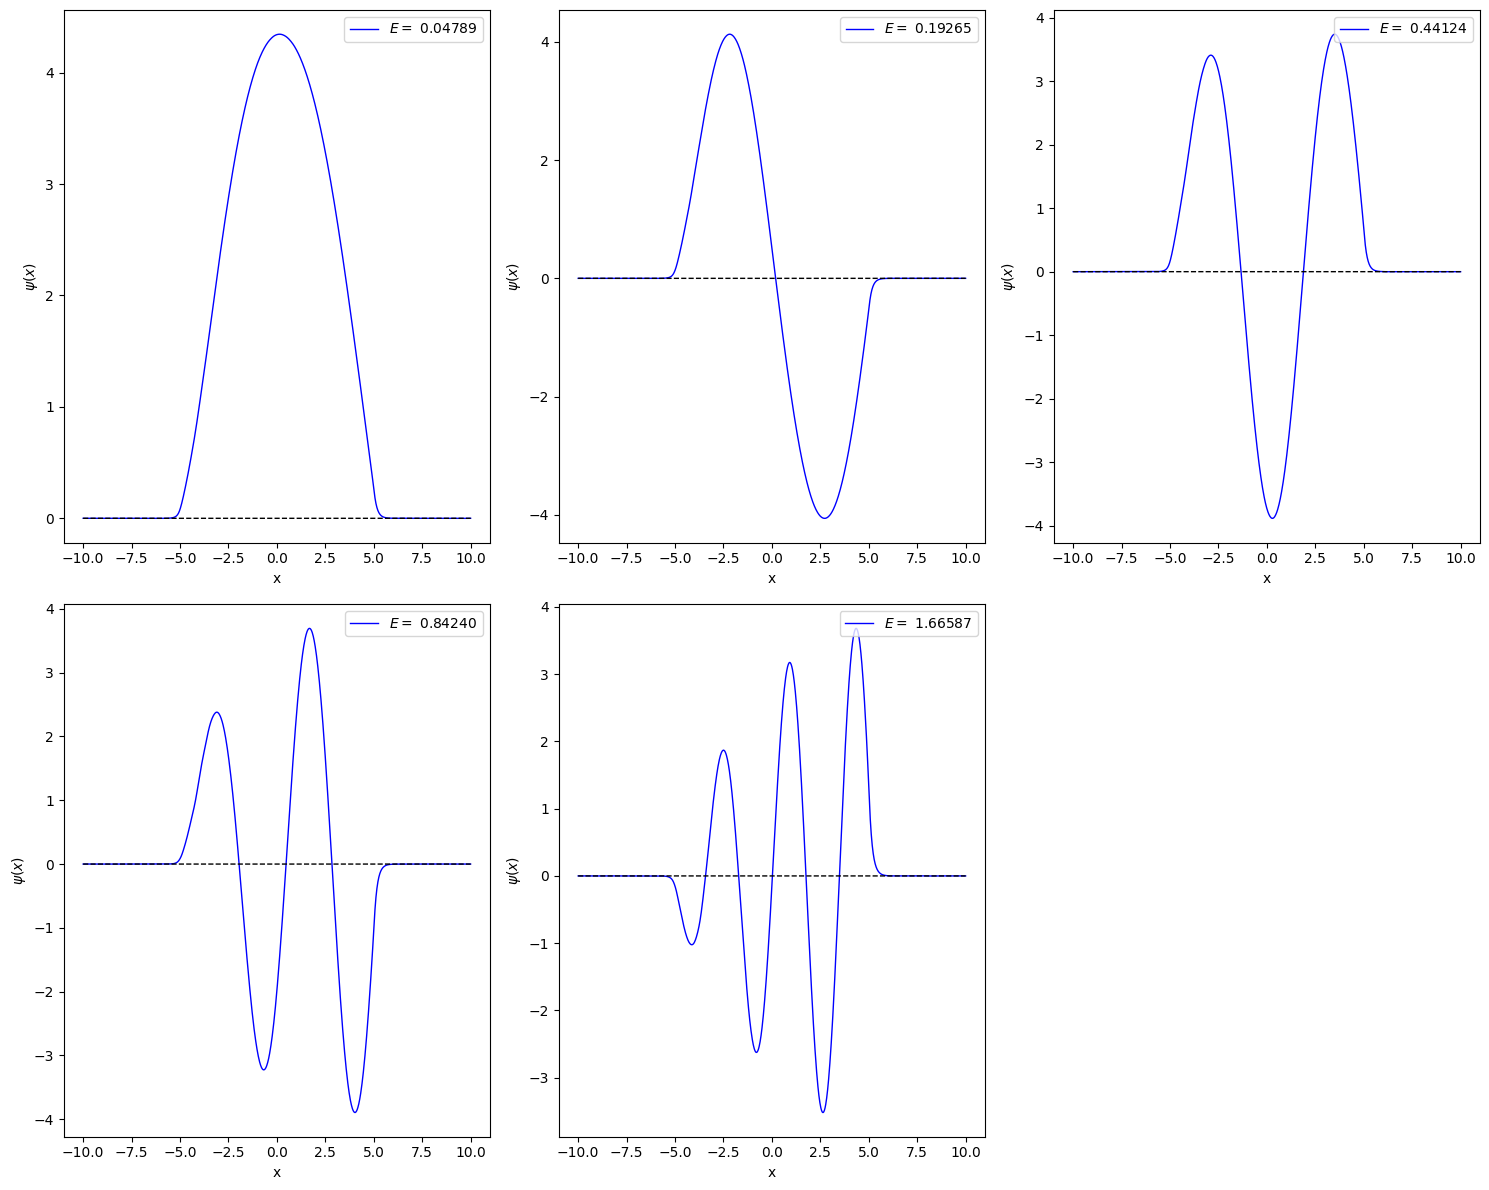

In [24]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eigs_arranged[:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    ax.plot(t_net, psi[:,index], color='blue', linewidth=1, label=f'$E =$ {eigs_arranged[index]:.5f}')
    ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper right')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

### Comparison with Exact Solution